**Import Libraries**

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
#! pip install bayesian-optimization
from bayes_opt import BayesianOptimization


from lightgbm import LGBMClassifier
import lightgbm as lgb

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
import matplotlib.pyplot as plt


from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

**Constants**

In [ ]:
#/DataDictionaryWiDS2021.csv
trainingFileName = r"/TrainingWiDS2021.csv"
dataDictionaryFileName = r"/DataDictionaryWiDS2021.csv"
submissionFile = r"/UnlabeledWiDS2021.csv"


**Helper Methods**

In [ ]:
def printDetails(df,columnsList):
    catDesc  = df[df['Variable Name'].isin(columnsList)]
    print(catDesc)

def nullpercent(df):
    print(df.isna().sum()/(len(df)))



In [ ]:
# make general plots to examine each feature
def plot_var(train,col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the Diabetes status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(train.loc[train[col_name].notnull(), col_name], kde=True, ax=ax1)
    else:
        sns.countplot(train[col_name], order=sorted(train[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by Diabetes or not
    if continuous:
        sns.boxplot(x=col_name, y='diabetes_mellitus', data=train, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Diabetes Status')
    else:
        Diabetes_rates = train.groupby(col_name)['diabetes_mellitus'].value_counts(normalize=True)[:,1]
        sns.barplot(x=Diabetes_rates.index, y=Diabetes_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction Diabetes')
        ax2.set_title('Diabetes Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
   # plot3: kde plot of the variable gropued by Diabetes_status
    if continuous:
        facet = sns.FacetGrid(train, hue = 'diabetes_mellitus', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        facet.set(xlim=(train[col_name].min(), train[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='diabetes_mellitus', data=train, order=sorted(train[col_name].unique()) )
     
    plt.tight_layout()

In [ ]:
def initialAnalysis(source):   
    numeric = source.select_dtypes(include=np.number).columns
    categorical = source.select_dtypes(include=[np.object,'category']).columns 
    
    datetime = source.select_dtypes(include=np.datetime64).columns
    bool_cols = [col for col in source 
             if np.isin(df[col].dropna().unique(), [0, 1]).all()]
    
    numeric = numeric.difference(bool_cols)
    return categorical,numeric,datetime,bool_cols
    


In [ ]:
def dropHighlyCorrelatedColumns(source,indices):
    cor_matrix =source[indices].corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    source = source.drop(columns= df[to_drop].columns, axis=1)
    return source

In [ ]:
def ImputeData(df1):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  #imp_mean = RobustScaler()
  X = imp_mean.fit_transform(df1[numeric])
  df1[numeric] = X
  

  rs = RobustScaler()
  X = imp_mean.fit_transform(df1[numeric])
  df1[numeric] = X
  
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X = imp_mean.fit_transform(df1[categorical])
  df1[categorical] = X
  return df1

#most_frequent

In [ ]:
def FitAndScore(X_test,X_train,Y_test,Y_train,grid):
    grid.fit(X_train, y_train)  
    y_pred_test =  grid.predict(X_test)
    y_prob_xgb = grid.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,y_prob_xgb)
    roc_auc = auc(fpr, tpr)
    return roc_auc,grid

In [ ]:
def getDummiesAndDropColumn(df,columnname):
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[columnname])
    # Drop column B as it is now encoded
    df = df.drop(columnname,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

In [ ]:
# prepare input data
def prepare_inputs(X):
    oe = OrdinalEncoder()
    X_ret = oe.fit_transform(X)    
    return X_ret

In [ ]:
def generateBinsAndLabels(name,number):
  bins = []
  labels =[]
  for i in range(number):
    bins.append(i/number)
    labels.append('name_'+str(i))

  return bin , labels
  

In [ ]:
def GenerateSubmission(classifier,df_submission):
  #test = pd.read_csv(submissionFile)
  y_pred_xgb = xgGrid.predict(df_submission)
  y_prob_xgb = xgGrid.predict_proba(df_submission)[:,1]

  df_submission['diabetes_mellitus']=y_prob_xgb

  df_submission=df_submission.reset_index()
#df_submission.head()


  test_id = sub_encounter_id
  test_preds = df_submission.diabetes_mellitus.values
  submission = pd.DataFrame.from_dict({
      'encounter_id':test_id.astype(int),
      'diabetes_mellitus':test_preds,
  })

submission.to_csv(r'/submission.csv', index=False)

In [ ]:
def getDummiesAndDropColumn(df,columnname):
    # Get one hot encoding of columns u
    one_hot = pd.get_dummies(df[columnname])
    one_hot.columns = columnname+"_"+one_hot.columns
    # Drop column B as it is now encoded
    df = df.drop(columnname,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

**EDA starts from here**

In [ ]:
description = pd.read_csv(dataDictionaryFileName)

In [ ]:
df = pd.read_csv(trainingFileName,low_memory=False)
df.shape

(130157, 181)

In [ ]:

df_submission = pd.read_csv(submissionFile)
df_submission.shape


In [ ]:
df_backup = df.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


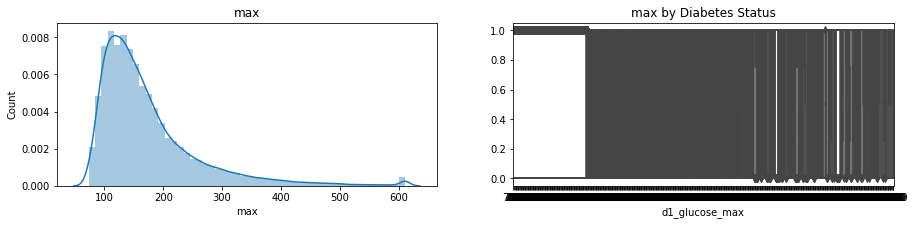

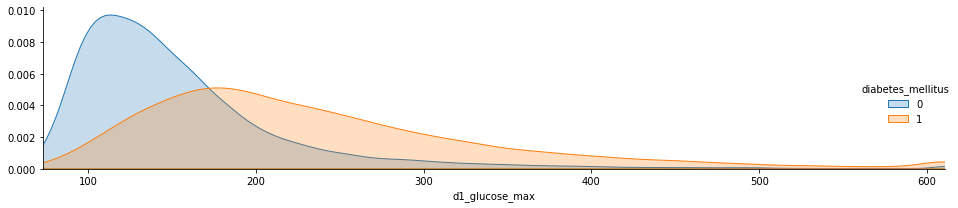

In [ ]:
#plot_var(df,'d1_glucose_max','max',True)

In [ ]:
#bins,labels_names  = generateBinsAndLabels('glucose',10)
#df['age'] = pd.qcut(df['age'],q=[bins],labels=labels_names)
#df.drop(['age'],axis=1)
#df.head()

### Get columns and categories . Might be helpful later

In [ ]:
categorical,numeric,datetime,bool_cols=initialAnalysis(df)


## Check for Sparse or null numeric and categorical columns 
### Drop columns with more than 60% null 

In [ ]:
df2  = df[numeric].replace([0,' ','NULL'],np.nan)
df2 =  df2.dropna(thresh=df.shape[0]*0.8,how='all',axis=1)

tobeDropped  = df[numeric].columns.difference(df2.columns)
df = df.drop(tobeDropped,axis=1)
df_submission.drop(tobeDropped,axis=1,inplace=True)

**Categorical columns**

In [ ]:
df2  = df[categorical].replace([0,' ','NULL'],np.nan)
df2 =  df2.dropna(thresh=df.shape[0]*0.8,how='all',axis=1)
tobeDropped = df[categorical].columns.difference(df2.columns)
df = df.drop(tobeDropped,axis=1)
df_submission.drop(tobeDropped,axis=1,inplace=True)

In [ ]:
df.shape ,df_submission.shape

((130157, 102), (10234, 101))

In [ ]:
## Get various categories of columns
categorical,numeric,datetime,bool_cols = initialAnalysis(df)

### Replace Nulls 

In [ ]:
df = ImputeData(df)
df_submission = ImputeData(df_submission)

Remove Outliers

In [ ]:
#df= df[df[numeric].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [ ]:
target = df.columns[-1]
#target

In [ ]:
fill_mode = lambda col: col.fillna(col.mode()[0])
df[bool_cols] = df[bool_cols].apply(fill_mode, axis=0)
df_submission[bool_cols[:-1]] = df_submission[bool_cols[:-1]].apply(fill_mode, axis=0)

#df_submission[bool_cols[:-1]] = df_submission[bool_cols[:-1]].fillna(df_submission[bool_cols[:-1]].mode())

In [ ]:
df[target] = df[target].fillna(df[target].mode()[0])

### Remove unnamed column and pop out encounterID , targetVariable

In [ ]:
df = df.drop(df.columns[0],axis=1)
Y = df.pop(target)
encounter_id = df.pop(df.columns[0])
df_submission.drop(df_submission.columns[0],axis=1,inplace=True)

In [ ]:
categorical,numeric,datetime,bool_cols = initialAnalysis(df)

In [ ]:
scaler = MinMaxScaler()
df[numeric] = scaler.fit_transform(df[numeric])
df_submission[numeric] = scaler.fit_transform(df_submission[numeric])
sub_encounter_id = df_submission.pop('encounter_id')
categorical,numeric,datetime,bool_cols = initialAnalysis(df)

**GET MOST IMPORTANT NUMERIC FEATURES**

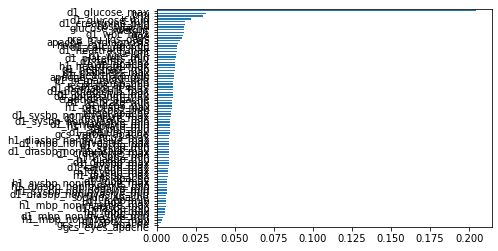

In [ ]:
dt= DecisionTreeClassifier()
dt.fit(df[numeric],Y)
feat_importances2 = pd.Series(dt.feature_importances_, index=df[numeric].columns)
feat_importances2.sort_values(ascending=True).plot(kind='barh')
plt.show()

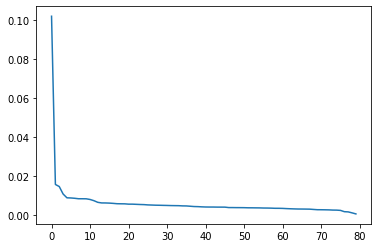

In [ ]:
size = feat_importances2.shape[0]
sns.lineplot(y=feat_importances2.sort_values(ascending=False)/2,x=range(size))

In [ ]:
## Get top two numerical columns
##numericals = feat_importances2.sort_values(ascending=False).head(60).index
## drop everything else.
##tobeDropped = numeric.difference(numericals)
tobeDropped = feat_importances2[feat_importances2 <=0.005].index
df.drop(tobeDropped,axis=1,inplace=True)
df_submission.drop(tobeDropped,axis=1,inplace=True)



**Get most important Categorical features**

In [ ]:
for cat in categorical:
    df = getDummiesAndDropColumn(df,cat)
    df_submission =getDummiesAndDropColumn(df_submission,cat)

In [ ]:
others = df.columns.difference(numeric)
#others
df[others].fillna(df[others].mode().iloc[0],inplace= True)



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
others = df_submission.columns.intersection(others)
df_submission[others].fillna(df_submission[others].mode().iloc[0],inplace= True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
df = df.dropna();
Y = Y[df.index]

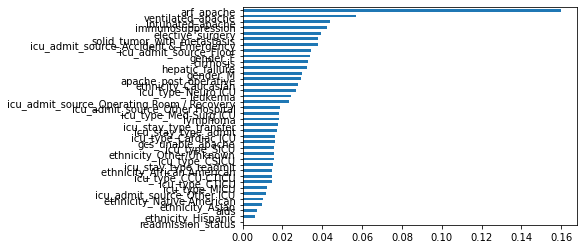

In [ ]:
df2 = df[others]

dt.fit(df2,Y)
feat_importances2 = pd.Series(dt.feature_importances_, index=df2.columns)
feat_importances2.sort_values(ascending=True).plot(kind='barh')
plt.show()

In [ ]:
#feat_importances2.sort_values(ascending=True).index

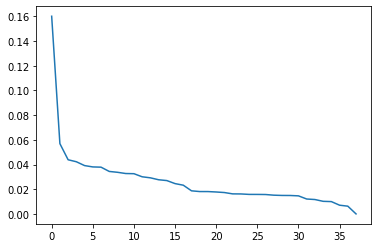

In [ ]:
len = feat_importances2.shape[0]
sns.lineplot(y=feat_importances2.sort_values(ascending=False),x=range(len))

In [ ]:
tobeDropped = feat_importances2[feat_importances2 <=0.005].index

In [ ]:
df.drop(tobeDropped,axis = 1,inplace=True)
df_submission.drop(tobeDropped,axis = 1,inplace=True)

In [ ]:
def returnMetrics(y_test,y_test_pred):
    acc = accuracy_score(y_test,y_test_pred)
    cm = confusion_matrix(y_test,y_test_pred)
    cr = classification_report(y_test,y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    return acc,cm,cr,f1

In [ ]:
## sort input data 
df.sort_index(axis=1, inplace=True)
Y = Y[df.index]

# Sort submission data as well.
df_submission.sort_index(axis=1, inplace=True)

In [ ]:
missing = df.columns.difference(df_submission.columns)
if missing.shape[0] >0:
  df_submission[missing] = df[missing].mode()[0]


**Split data to test and train**

In [ ]:
indices = df.index.values
X_train, X_test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2, random_state=42)
y_train, y_test = Y[indices_train],  Y[indices_test]
enc_train,enc_test = encounter_id[indices_train],encounter_id[indices_test]

In [ ]:
df_submission.drop(df_submission.columns.difference(df.columns),axis=1,inplace=True)

Hyper Optimize XGBooster

Bayesian Optimization

In [ ]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
     params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
     cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
     return cv_result['roc_auc_score'].iloc[-1]

In [ ]:
dtrain = xgb.DMatrix(df_train, label=y_train)

In [ ]:
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth':(3, 10),'gamma': (0, 1), 'learning_rate':(0,1),'n_estimators':(100,200)})

In [ ]:
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

{'gamma': 0.7341935597042867, 'learning_rate': 0.08615009038053989, 'max_depth': 9.66188095243959, 'n_estimators': 164.79007587847076}
{'gamma': 0.7341935597042867, 'learning_rate': 0.08615009038053989, 'max_depth': 9.66188095243959, 'n_estimators': 164.79007587847076}


In [ ]:
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [ ]:
classifier2 = xgb.XGBClassifier(**params).fit(df_test,y_test)

In [ ]:
roc,xgGrid =  FitAndScore(X_test,X_train,y_test,y_train,classifier2)
roc

0.8638659344298218

In [ ]:
GenerateSubmission(xgGrid,df_submission)

**Hyper Optimize LightGBM**

In [ ]:
param_test ={'n_estimators': sp_randint(100, 500), 'max_depth': sp_randint(7,20)}

In [ ]:
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=5,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(X_train,y_train)

In [ ]:
roc_auc,lgbmClassifier = FitAndScore(X_test,X_train,y_test,y_train,gs.best_estimator_)
roc_auc

0.8643057063624786

In [ ]:
GenerateSubmission(lgbmClassifier,df_submission)